### Package load

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

# Reload an IPython extension by its module name.
%load_ext autoreload 
%autoreload 2
# 파이썬 코드를 실행하기 전에 항상 모든 모듈을 Reload

# One to Many function

### Standard Data Fitting

Before we talk about Mixture Density Networks, let's perform some standard data fitting using PyTorch to make sure everything works. Neural nets with even one hidden layer can be universal function approximators, so let's try to fit a sinusoidal function.

$y_{true}(x)=7 \sin( 0.75 x ) + 0.5 x + \epsilon$, $y_{true}(x)$: this function $y_{true}$ takes $x$ as input.

$7 \sin( 0.75 x)$: a large periodic $\sin$ wave.
, $0.5 x$: add a slight upward slope.  $\epsilon$: add some random noise "epsilon".

Then we generate random inputs $x$ to get random samples of $y(x)$. Later we will train a neural net on this data.

In [2]:
def generate_data(n_samples):
    epsilon = np.random.normal(size=(n_samples))
    x_data = np.random.uniform(-10.5, 10.5, n_samples)
    y_data = 7*np.sin(0.75*x_data) + 0.5*x_data + epsilon
    return x_data, y_data
    
n_samples = 1000
x_data, y_data = generate_data(n_samples)

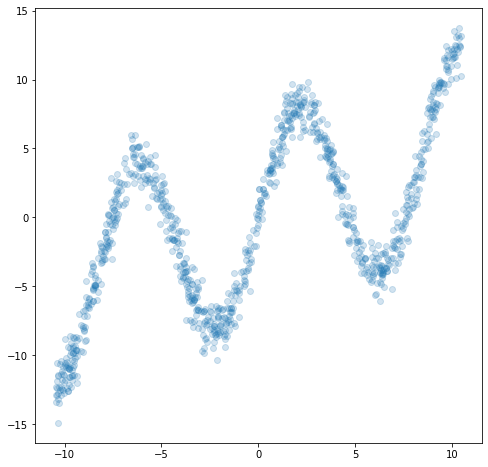

In [3]:
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.2)
plt.show()

We will use this data to train a neural network with one hidden layer. This neural network is described by the following equation:

$y_{pred}(x) = w_{out} \tanh( w_{in} x + b_{in}) + b_{out}$

- $y_{pred}(x)$: this function $y_{pred}$ takes $x$ as input.
- $w_{in}, w_{out}$: weights for the input and output layers.
- $b_{in}, b_{out}$: biases for the input and output layers.
- $\tanh$: a nonlinear activation function.

Let's create this network using 20 hidden nodes.

In [4]:
n_input = 1
n_hidden = 20
n_output = 1

model = nn.Sequential(nn.Linear(n_input, n_hidden),
                        nn.Tanh(),
                        nn.Linear(n_hidden, n_output))

To train the network we must define a loss function. Also called a "cost function", this is a description of what counts as "better" or "worse" results, and allows us to modify the network to achieve the best results.

We will use the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) loss function.

In [5]:
loss_fn = nn.MSELoss()

We also need to pick an optimizer. Optimizers use the loss to determine which parameters in the network should be changed, and how much.

We will use the[ RMSprop ](https://ruder.io/optimizing-gradient-descent/index.html#rmsprop)optimizer, which happens to work well for this problem.

In [6]:
optimizer = torch.optim.RMSprop(model.parameters())

Now let's move our data from numpy to PyTorch. This requires:

1. Converting the data from np.float64 (numpy default) to np.float32 (Torch default).
2. Reshaping the data from (n_samples) to (n_samples, n_input). Typically the first dimension is your batch size, but here we are processing all the samples in one batch.
3. Convert from a numpy array to a PyTorch tensor.
4. Initialize an input and output Variable that we can feed the x and y tensors.


We will use this naming convention:

- numpy arrays x_data
- PyTorch tensors x_tensor
- PyTorch Variables x_variable

In [7]:
# change data type and shape, move from numpy to torch
# note that we need to convert all data to np.float32 for pytorch
x_tensor = torch.from_numpy(np.float32(x_data).reshape(n_samples, n_input))
y_tensor = torch.from_numpy(np.float32(y_data).reshape(n_samples, n_input))
x_variable = Variable(x_tensor)
y_variable = Variable(y_tensor, requires_grad=False)


Now let's define a training loop. It will use the optimizer to minimize the loss function by modifying the network's parameters.

In [8]:
def train():
    for epoch in range(3000):
        y_pred = model(x_variable) # make a prediction
        loss = loss_fn(y_pred, y_variable) # compute the loss
        optimizer.zero_grad() # prepare the optimizer
        loss.backward() # compute the contribution of each parameter to the loss
        optimizer.step() # modify the parameters

        if epoch % 300 == 0:
            print(epoch, loss.data)

train()

0 tensor(40.8732)
300 tensor(15.4259)
600 tensor(11.8127)
900 tensor(5.0780)
1200 tensor(1.9266)
1500 tensor(1.1753)
1800 tensor(1.1238)
2100 tensor(1.1157)
2400 tensor(1.1112)
2700 tensor(1.1051)


Let's see how it performs by processing some evenly spaced samples.

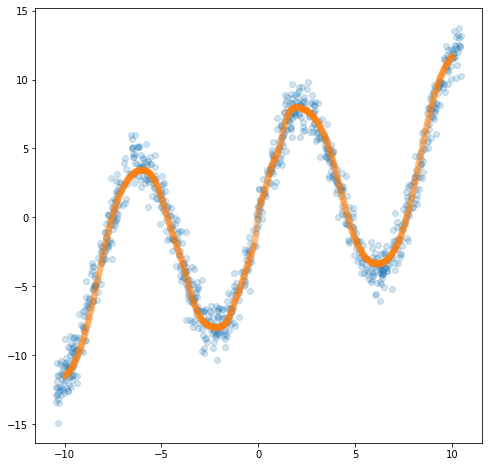

In [9]:
# evenly spaced samples from -10 to 10
x_test_data = np.linspace(-10, 10, n_samples)

# change data shape, move from numpy to torch
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(n_samples, n_input))
x_test_variable = Variable(x_test_tensor)
y_test_variable = model(x_test_variable)

# move from torch back to numpy
y_test_data = y_test_variable.data.numpy()

# plot the original data and the test data
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.2)
plt.scatter(x_test_data, y_test_data, alpha=0.2)
plt.show()

The network can fit this sinusoidal data quite well, as expected. However, this type of fitting only when we want to approximate a one-to-one, or many-to-one relationship.

Suppose we invert the training data so we are predicting $x(y)$ instead of $y(x)$.

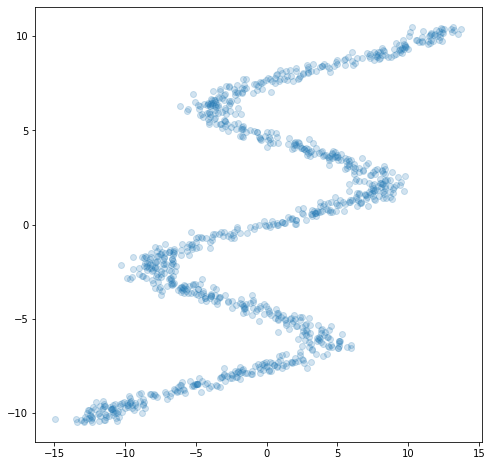

In [10]:
# plot x against y instead of y against x
plt.figure(figsize=(8, 8))
plt.scatter(y_data, x_data, alpha=0.2)
plt.show()

If we use the same method to fit this data, it won't work well because the network can't output multiple values for each input. Because we used mean squared error loss, the network will try to output the average output value for each input.

In [11]:
x_variable.data = y_tensor
y_variable.data = x_tensor

train()

0 tensor(48.9645)
300 tensor(20.9491)
600 tensor(20.8975)
900 tensor(20.8535)
1200 tensor(20.8198)
1500 tensor(20.7912)
1800 tensor(20.7645)
2100 tensor(20.7389)
2400 tensor(20.7053)
2700 tensor(20.6881)


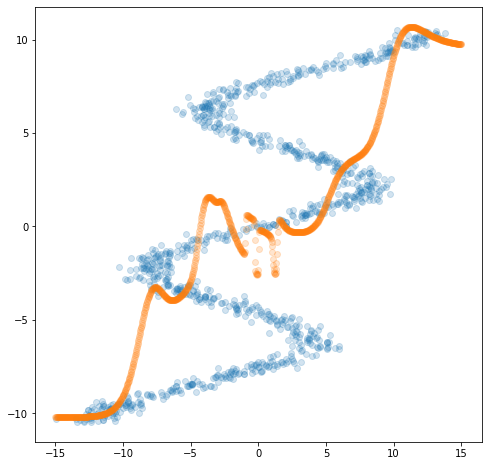

In [12]:
x_test_data = np.linspace(-15, 15, n_samples)
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(n_samples, n_input))
x_test_variable.data = x_test_tensor

y_test_variable = model(x_test_variable)

# move from torch back to numpy
y_test_data = y_test_variable.data.numpy()

# plot the original data and the test data
plt.figure(figsize=(8, 8))
plt.scatter(y_data, x_data, alpha=0.2)
plt.scatter(x_test_data, y_test_data, alpha=0.2)
plt.show()

## Mixture Density Networks

## Mixture Density Networks


Mixture Density Networks, developed by Christopher Bishop in the 1990s, are one way to produce multiple outputs from a single input. MDN predicts a probability distribution of possible output values. Then can sample several possible different output values for a given input.

This concept is quite powerful, and can be employed many current areas of machine learning research. It also allows us to calculate a sort of confidence factor in the predictions that the network is making.

The inverted sinusoid data we chose is not just a toy problem. In the paper introducing MDNs an inverted sinusoid is used to describe the angle we need to move a robot arm to achieve a target location. MDNs are also used to model handwriting, where the next stroke is drawn from a probability distribution of multiple possibilities, rather than sticking to one prediction.

Bishop's implementation of MDNs will predict a class of probability distributions called Mixture of Gaussians or Gaussian Mixture Models, where the output value is modelled as a weighted sum of multiple Gaussians, each with different means and standard deviations.

So for each input $x$, we will predict a probability distribution function $P(y|x)$:

$P(y|x) = \sum_{k}^{K} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x))$

- $k$ is an index describing which Gaussian we are referencing. There are $K$ Gaussians total.
- $\sum_{k}^{K}$ is the summation operator. We sum every $k$ Gaussian across all $K$. You might also see $\sum_{k=0}^{K-1}$ or $\sum_{k=1}^{K}$ depending on whether an author is using zero-based numbering or not.
- $\Pi_k$ acts as a weight, or multiplier, for mixing every $k$ Gaussian. It is a function of the input $x$: $\Pi_k(x)$
- $\phi$ is the Gaussian function and returns the at $y$ for a given mean and standard deviation.
- $\mu_k$ and $\sigma_k$ are the parameters for the $k$ Gaussian: mean $\mu_k$ and standard deviation $\sigma_k$. Instead of being fixed for each Gaussian, they are also functions of the input $x$: $\mu_k(x)$ and $\sigma_k(x)$


All of $\sigma_{k}$ are positive, and all of the weights $\Pi$ sum to one:

$\sum_{k}^{K} \Pi_{k} = 1$

First our network must learn the functions $\Pi_{k}(x), \mu_{k}(x), \sigma_{k}(x)$ for every $k$ Gaussian. Then these functions can be used to generate individual parameters $\mu_k, \sigma_k, \Pi_k$ for a given input $x$. These parameters will be used to generate our pdf $P(y|x)$. Finally, to make a prediction, we will need to sample (pick a value) from this pdf.

In our implementation, we will use a neural network of one hidden layer with 20 nodes. This will feed into another layer that generates the parameters for 5 mixtures: with 3 parameters $\Pi_k$, $\mu_k$, $\sigma_k$ for each Gaussian $k$.

Our definition will be split into three parts.

First we will compute 20 hidden values $z_h$ from our input $x$.

$z_h(x) = \tanh( W_{in} x + b_{in})$

Second, we will use these hidden values $z_h$ to compute our three sets of parameters $\Pi, \sigma, \mu$:

$
z_\Pi = W_{\Pi} z_h + b_{\Pi}\\
z_\sigma = W_{\sigma} z_h + b_{\sigma}\\
z_\mu = W_{\mu} z_h + b_{\mu}
$

Third, we will use the output of these layers to determine the parameters of the Gaussians.

$
\Pi = \frac{\exp(z_{\Pi})}{\sum_{k}^{K} \exp(z_{\Pi_k})}\\
\sigma = \exp(z_{\sigma})\\
\mu = z_{\mu}
$

$\exp(x)$ is the exponential function also written as $e^x$
We use a softmax operator to ensure that $\Pi$ sums to one across all $k$, and the exponential function ensures that each weight $\Pi_k$ is positive. We also use the exponential function to ensure that every $\sigma_k$ is positive.

Let's define our MDN network.

In [13]:
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu

We cannot use the MSELoss() function for this task, because the output is an entire description of the probability distribution and not just a single value. A more suitable loss function is the logarithm of the likelihood of the output distribution vs the training data:

$loss(y | x) = -\log[ \sum_{k}^{K} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x)) ]$

So for every $x$ input and $y$ output pair in the training data set, we can compute a loss based on the predicted distribution versus the actual distribution, and then attempt the minimise the sum of all the costs combined. To those who are familiar with logistic regression and cross entropy minimisation of softmax, this is a similar approach, but with non-discretised states.

We have to implement this cost function ourselves:

In [14]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

Let's create our MDN with 20 hidden nodes and 5 Gaussians.

In [15]:
network = MDN(n_hidden=20, n_gaussians=5)

We'll use a different optimizer this time called Adam that is more suited to this task.

In [16]:
optimizer = torch.optim.Adam(network.parameters())

We could generate more data to train the MDN, but what we have is nearly enough.

In [17]:
mdn_x_data = y_data
mdn_y_data = x_data

mdn_x_tensor = y_tensor
mdn_y_tensor = x_tensor

x_variable = Variable(mdn_x_tensor)
y_variable = Variable(mdn_y_tensor, requires_grad=False)


Finally, let's define a new training loop. We need a training loop that can handle the new loss function, and the MDN needs to train longer than the previous network.

In [18]:
def train_mdn():
    for epoch in range(10000):
        pi_variable, sigma_variable, mu_variable = network(x_variable)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(epoch, loss.data)

train_mdn()

0 tensor(10.6459)
500 tensor(3.0851)
1000 tensor(2.9914)
1500 tensor(2.8943)
2000 tensor(2.7829)
2500 tensor(2.6851)
3000 tensor(2.5265)
3500 tensor(2.4050)
4000 tensor(2.3398)
4500 tensor(2.2913)
5000 tensor(2.0825)
5500 tensor(1.9821)
6000 tensor(1.9273)
6500 tensor(1.8902)
7000 tensor(1.8528)
7500 tensor(1.8153)
8000 tensor(1.7908)
8500 tensor(1.7749)
9000 tensor(1.7943)
9500 tensor(1.7779)


Once the training is finished, we can observe all the parameters for the Gaussians and see how they vary with respect to the input $x$.

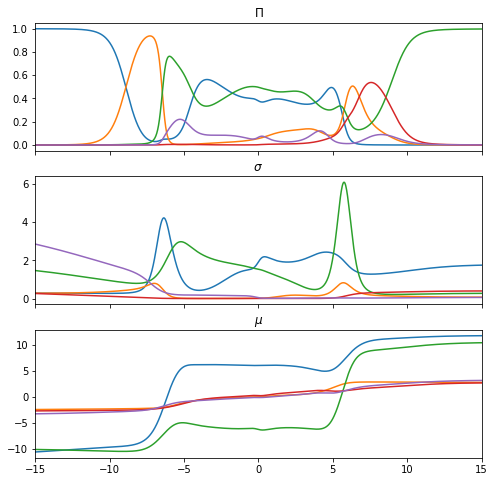

In [23]:
pi_variable, sigma_variable, mu_variable = network(x_test_variable)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x_test_data, pi_data)
ax1.set_title('$\Pi$')
ax2.plot(x_test_data, sigma_data)
ax2.set_title('$\sigma$')
ax3.plot(x_test_data, mu_data)
ax3.set_title('$\mu$')
plt.xlim([-15,15])
plt.show()


We can also plot the $\mu$ of each Gaussian with respect to $x$, and show the range of by highlighting a region between $\mu-\sigma$ and $\mu+\sigma$.

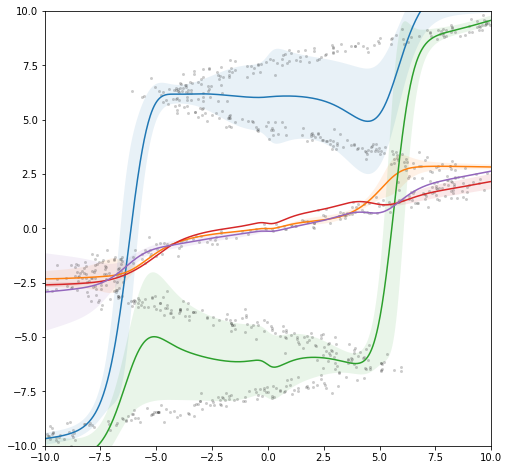

In [24]:

plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(x_test_data, mu_k)
    plt.fill_between(x_test_data, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(mdn_x_data, mdn_y_data, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In the plot above, we see that for every point on the $x$-axis, there are multiple lines or states where $y$ may be, and we select these states with probabilities modelled by $\Pi$. Note that the network won't find an ideal solution every time. It's possible to get lower loss by using more Gaussians, but the results are harder to interpret.

If we want to sample from the network we will need to pick a Gaussian $k$ and pick a value (sample) from that Gaussian. Here we use a trick called [Gumbel softmax sampling](http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/) to pick our $k$. We treat the $\Pi$ weights as a discrete distribution of probabilities, and sample one $k$ for each row of pi_data.

In [25]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

Now that we have selected $k$ for each row, we can select $\sigma$ and $\mu$ as well. We will use np.random.randn to sample from each Gaussian, scaling it by $\sigma$ and offsetting it by $\mu$.

In [26]:
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

With these sampled $y$ values, we can overlay them on the original distribution to see how accurately the network captures the shape.

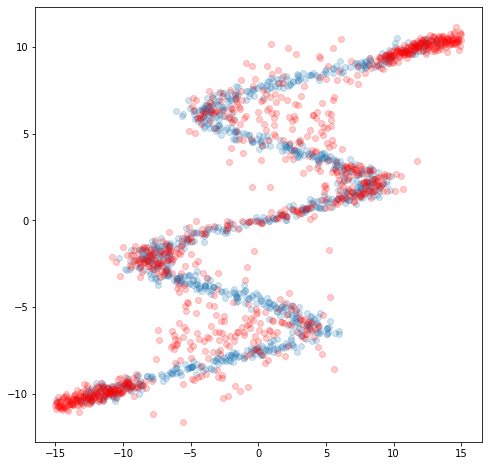

In [28]:
plt.figure(figsize=(8, 8))
plt.scatter(mdn_x_data, mdn_y_data, alpha=0.2)
plt.scatter(x_test_data, sampled, alpha=0.2, color='red')
plt.show()

### Another Example


In [29]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.rcParams['figure.figsize'] = (8, 8)
np.random.seed(42)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate data

To begin with, let's generate a training dataset that matches that from PRML, p. 272. Specifically, let's generate a matrix $\mathbf{X}$ of $n$ observations of a 1-dimensional variable $\mathbf{x}$ by sampling uniformly over the interval $[0, 1)$, and then generate a corresponding matrix $\mathbf{Y}$ of $n$ target observations of a 1-dimensional variable $\mathbf{y}$ by computing

$$\mathbf{Y} = \mathbf{X} + 0.3\sin(2\pi \mathbf{X}) + \mathbf{noise}\text{,}$$
where $\mathbf{noise}$ is a vector of $n$ uniform values sampled over the interval $[-0.1, 0.1)$.

In [30]:
# generate data
n = 2500
d = 1
t = 1
x_train = np.random.uniform(0, 1, (n, d)).astype(np.float32)
noise = np.random.uniform(-0.1, 0.1, (n, d)).astype(np.float32)
y_train = x_train + 0.3*np.sin(2*np.pi*x_train) + noise
x_test = np.linspace(0, 1, n).reshape(-1, 1).astype(np.float32)

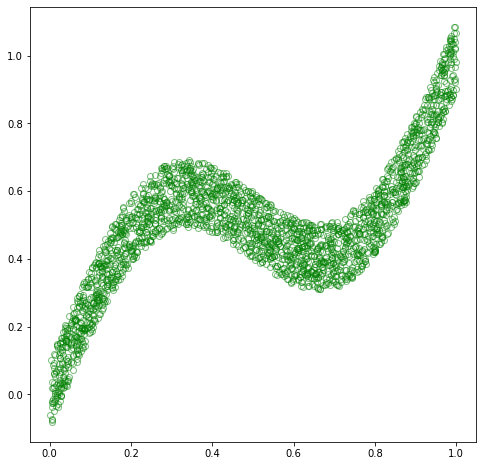

In [31]:
# plot
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train, y_train, 'go', alpha=0.5, markerfacecolor='none')
plt.show()

###Train a model

Now, let's train a model to learn the process that generated this dataset, i.e., the mapping from $\mathbf{x}$ to $\mathbf{y}$, or the conditional distribution $p(\mathbf{y}|\mathbf{x})$. For this dataset, $p(\mathbf{y}|\mathbf{x})$ is unimodal, i.e., there appears to be a single distribution over $\mathbf{y}$ for each observation of $\mathbf{x}$. Thus, we could assume a Gaussian distribution for $p(\mathbf{y}|\mathbf{x})$, and treat this problem as a standard regression problem. Therefore, we need to construct a model that accepts an example $\mathbf{x}_i$ and produces a value $\mathbf{out}_i$, which we can interpret as the mean parameter of a Gaussian distribution for $\mathbf{y}_i$. We can then construct a loss function as the negative log likelihood assuming a Gaussian distribution, and optimize this loss w.r.t. the parameters of our model. In terms of the actual model, we can make use of a neural network as a general framework for function approximation, and construct a simple, two-layer, non-linear neural net with a sufficient number of parameters to be able to fit the given dataset.

In [32]:
# define a simple neural net
h = 15
w1 = Variable(torch.randn(d, h) * np.sqrt(1/d), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w2 = Variable(torch.randn(h, t) * np.sqrt(1/h), requires_grad=True)
b2 = Variable(torch.zeros(1, t), requires_grad=True)

def forward(x):
  out = torch.tanh(x.mm(w1) + b1)  # a relu introduces kinks in the predicted curve
  out = out.mm(w2) + b2
  return out

# wrap up the data as Variables
x = Variable(torch.from_numpy(x_train))
y = Variable(torch.from_numpy(y_train))

# select an optimizer
# NOTE: there are a few options here -- feel free to explore!
# opt = optim.SGD([w1, b1, w2, b2], lr=0.1)
opt = optim.SGD([w1, b1, w2, b2], lr=0.09, momentum=0.9, nesterov=True)
# opt = optim.RMSprop([w1, b1, w2, b2], lr=0.002, alpha=0.999)
# opt = optim.Adam([w1, b1, w2, b2], lr=0.09)

# optimize
# 10000 for SGD, 2000 for SGD w/ nesterov momentum, 4000 for RMSprop, 800 for Adam
for e in range(2000):
  opt.zero_grad()
  out = forward(x)
  loss = F.mse_loss(out, y)  # negative log likelihood assuming a Gaussian distribution
  if e % 100 == 0:
    print(e, loss.data)
  loss.backward()
  opt.step()

0 tensor(0.1319)
100 tensor(0.0212)
200 tensor(0.0207)
300 tensor(0.0200)
400 tensor(0.0188)
500 tensor(0.0170)
600 tensor(0.0142)
700 tensor(0.0103)
800 tensor(0.0065)
900 tensor(0.0048)
1000 tensor(0.0043)
1100 tensor(0.0047)
1200 tensor(0.0043)
1300 tensor(0.0040)
1400 tensor(0.0039)
1500 tensor(0.0037)
1600 tensor(0.0036)
1700 tensor(0.0036)
1800 tensor(0.0035)
1900 tensor(0.0035)


Now, let's make predictions and plot the values against the original dataset to see how well we are able to approximate the training dataset.

In [33]:
# predict
out = forward(Variable(torch.from_numpy(x_test)))

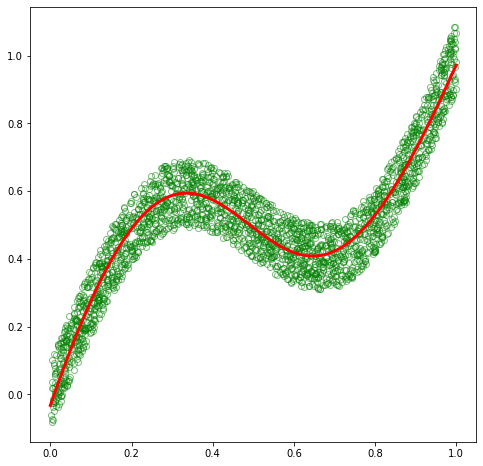

In [34]:
# plot
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train, y_train, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, out.data.numpy(), 'r', linewidth=3.0)
plt.show()

Inverse problem
To motivate the usefulness of MDNs, let's invert the problem by swapping $\mathbf{X}$ and $\mathbf{Y}$ as

$$\mathbf{X} = \mathbf{Y} + 0.3\sin(2\pi \mathbf{Y}) + \mathbf{noise}\text{,}$$
and then solve for $\mathbf{Y}$.

In [35]:
x_train_inv = y_train
y_train_inv = x_train
x_test = np.linspace(-0.1, 1.1, n).reshape(-1, 1).astype(np.float32)  # new x has a slightly different range

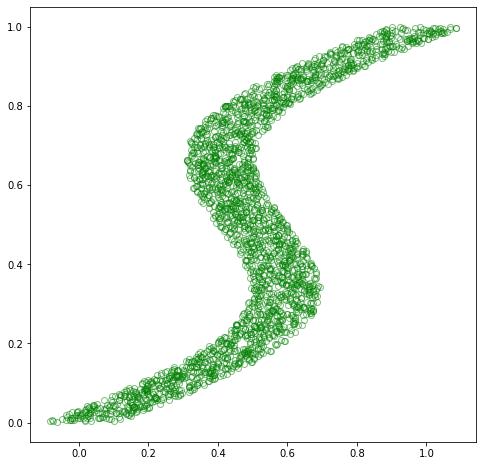

In [36]:
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.show()

Let's make use of the same model structure, fit this new dataset, and then get out of here.

In [37]:
# define a simple neural net
h = 15
w1 = Variable(torch.randn(d, h) * np.sqrt(1/d), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w2 = Variable(torch.randn(h, t) * np.sqrt(1/h), requires_grad=True)
b2 = Variable(torch.zeros(1, t), requires_grad=True)

def forward(x):
  out = torch.tanh(x.mm(w1) + b1)  # a relu introduces kinks in the predicted curve
  out = out.mm(w2) + b2
  return out

# wrap up the inverse data as Variables
x = Variable(torch.from_numpy(x_train_inv))
y = Variable(torch.from_numpy(y_train_inv))

# select an optimizer
# opt = optim.SGD([w1, b1, w2, b2], lr=0.1)
# opt = optim.SGD([w1, b1, w2, b2], lr=0.09, momentum=0.9, nesterov=True)
# opt = optim.RMSprop([w1, b1, w2, b2], lr=0.002, alpha=0.999)
opt = optim.Adam([w1, b1, w2, b2], lr=0.09)

# optimize
for e in range(2000):
  opt.zero_grad()
  out = forward(x)
  loss = F.mse_loss(out, y)  # negative log likelihood assuming a Gaussian distribution
  if e % 100 == 0:
    print(e, loss.data)
  loss.backward()
  opt.step()

0 tensor(0.3316)
100 tensor(0.0474)
200 tensor(0.0473)
300 tensor(0.0473)
400 tensor(0.0472)
500 tensor(0.0467)
600 tensor(0.0450)
700 tensor(0.0439)
800 tensor(0.0422)
900 tensor(0.0406)
1000 tensor(0.0403)
1100 tensor(0.0400)
1200 tensor(0.0400)
1300 tensor(0.0399)
1400 tensor(0.0401)
1500 tensor(0.0399)
1600 tensor(0.0399)
1700 tensor(0.0400)
1800 tensor(0.0399)
1900 tensor(0.0398)


In [38]:
# predict
out = forward(Variable(torch.from_numpy(x_test)))

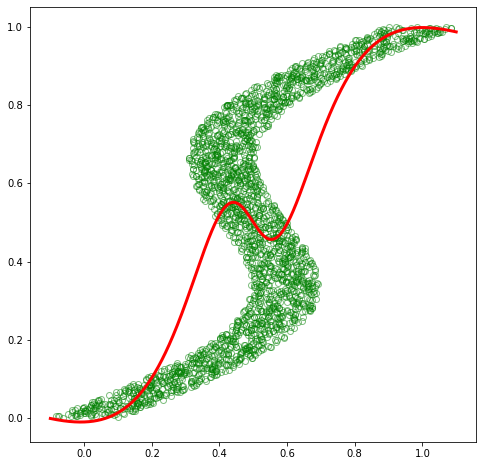

In [39]:
# plot
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, out.data.numpy(), 'r', linewidth=3.0)
plt.show()

Unfortunately, our model was not able to fit this inverse dataset at all. If we think about it a bit, we can see that this is a hard problem for a regular model with a single output to effectively fit. In the original dataset, although there was some amount of noise, there appeared to be a single, distinct distribution of $\mathbf{y}$ for each observation of $\mathbf{x}$, and thus a Gaussian distribution parameterized by a function of $\mathbf{x}$ was able to approximate $p(\mathbf{y}|\mathbf{x})$ quite well. However, in this inverse dataset, there appear to be multiple distinct distributions of $\mathbf{y}$ for many of the $\mathbf{x}$ observations, and thus a single Gaussian distribution is not able to approximate this multimodal conditional distribution.

What if our model could parameterize a mixture of Gaussian distributions to approximate $p(\mathbf{y}|\mathbf{x})$? Bingo – this is exactly the goal of a MDN. Let's try it!

### Mixture density networks
As mentioned at the beginning of our exploration, an MDN is a flexible framework for modeling an arbitrary conditional probability distribution $p(\mathbf{y}|\mathbf{x})$ as a mixture of distributions, parameterized by functions of the input $\mathbf{x}$. More specifically, we can construct an MDN by creating a neural network to parameterize a mixture model consisting of some predefined types of distributions. For this dataset, we'll continue to make use of Gaussian distributions, and thus our neural net will parameterize a Gaussian mixture model (GMM), which is effectively a normalized linear combination of $K$ Gaussian distributions. Formally, we can express the conditional probability $p(\mathbf{y}|\mathbf{x})$ as

$$
p(\mathbf{y}|\mathbf{x}) = \sum_k \pi_k(\mathbf{x}) N(\mathbf{y}|\boldsymbol{\mu}_k(\mathbf{x}), I\sigma_k^2(\mathbf{x})) \text{,}
$$
where $\boldsymbol{\pi}(\mathbf{x})$ is a normalized vector of $k$ mixing coefficients as a function of $\mathbf{x}$, and $N(\mathbf{y}|\boldsymbol{\mu}_k(\mathbf{x}), I\sigma_k^2(\mathbf{x}))$ is a Gaussian component density with means $\boldsymbol{\mu}_k(\mathbf{x})$ and variance $\sigma_k^2(\mathbf{x})$, both of which are also functions of $\mathbf{x}$. Note that although we use per-dimensional means, we simplify the covariance matrix to be isotropic, i.e., equal variances for each dimension of $\mathbf{x}$ (see PRML, p. 273). Also note that the mixing coefficients, means, and variances are all functions of the inputs $\mathbf{x}$, and as such, represent the outputs of our neural net.

Let's unpack this a bit. Essentially, we decided that our original approach of approximating $p(\mathbf{y}|\mathbf{x})$ with a single Gaussian distribution was insufficient, and that making use of multiple Gaussians could be more effective. Thus, we constructed a framework in which, for a given observation of $\mathbf{x}$, our model outputs the parameters for $K$ Gaussian distributions, as well as $K$ coefficients summing to one that indicate the relative amounts by which to combine the distributions. Then, for some new observation of $\mathbf{x}$, we could generate the parameters of this mixture model to form a complex distribution of $\mathbf{y}$, from which we could draw samples in various ways to generate probable predictions of $\mathbf{y}$.

In [40]:
# dimensionality of hidden layer
h = 50
# K mixing components (PRML p. 274)
# Can also formulate as a K-dimensional, one-hot
# encoded, latent variable $z$, and have the model
# produce values for $\mu_k = p(z_k = 1)$, i.e., the
# prob of each possible state of $z$. (PRML p. 430)
k = 30  # 3
# We specialize to the case of isotropic covariances (PRML p. 273),
# so the covariance matrix is diagonal with equal diagonal elements,
# i.e., the variances for each dimension of y are equivalent.
# therefore, the MDN outputs pi & sigma scalars for each mixture
# component, and a mu vector for each mixture component containing
# means for each target variable.
# NOTE: we could use the shorthand `d_out = 3*k`, since our target
# variable for this project only has a dimensionality of 1, but
# the following is more general.
# d_out = (t + 2) * k  # t is L from PRML p. 274
# NOTE: actually cleaner to just separate pi, sigma^2, & mu into
# separate functions.
d_pi = k
d_sigmasq = k
d_mu = t * k

w1 = Variable(torch.randn(d, h) * np.sqrt(2/(d+h)), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w_pi = Variable(torch.randn(h, d_pi) * np.sqrt(2/(d+h)), requires_grad=True)
b_pi = Variable(torch.zeros(1, d_pi), requires_grad=True)
w_sigmasq = Variable(torch.randn(h, d_sigmasq) * np.sqrt(2/(d+h)), requires_grad=True)
b_sigmasq = Variable(torch.zeros(1, d_sigmasq), requires_grad=True)
w_mu = Variable(torch.randn(h, d_mu) * np.sqrt(2/(d+h)), requires_grad=True)
b_mu = Variable(torch.zeros(1, d_mu), requires_grad=True)


##################### TO DO######################
def forward(x):
  #output shape : (n,h) / use tangent hyperbolic or leaky_relu
  out = F.tanh(x.mm(w1) + b1)
  # p(z_k = 1) for all k; K mixing components that sum to 1; shape (n, k)
  pi = F.softmax(out.mm(w_pi) + b_pi, dim=1)
  # K gaussian variances, which must be >= 0; shape (n, k)
  sigmasq = torch.exp(out.mm(w_sigmasq) + b_sigmasq)
  # K * L gaussian means; shape (n, k*t)
  mu = out.mm(w_mu) + b_mu
  return pi, sigmasq, mu
  

def gaussian_pdf(x, mu, sigmasq):
  # NOTE: we could use the new `torch.distributions` package for this now
  return (1/torch.sqrt(2*np.pi*sigmasq)) * torch.exp((-1/(2*sigmasq)) * torch.norm((x-mu), 2, 1)**2)   


def loss_fn(pi, sigmasq, mu, target):
  # PRML eq. 5.153, p. 275  
  # compute the likelihood p(y|x) by marginalizing p(z)p(y|x,z)
  # over z. for now, we assume the prior p(w) is equal to 1,
  # although we could also include it here.  to implement this,
  # we average over all examples of the negative log of the sum
  # over all K mixtures of p(z)p(y|x,z), assuming Gaussian
  # distributions.  here, p(z) is the prior over z, and p(y|x,z)
  # is the likelihood conditioned on z and x.
  losses = Variable(torch.zeros(n))  # p(y|x)
  for i in range(k):  # marginalize over z
    likelihood_z_x = gaussian_pdf(target, mu[:, i*t:(i+1)*t], sigmasq[:, i])
    prior_z = pi[:, i]
    losses += prior_z * likelihood_z_x
  loss = torch.mean(-torch.log(losses))
  return loss

In [41]:
opt = optim.Adam([w1, b1, w_pi, b_pi, w_sigmasq, b_sigmasq, w_mu, b_mu], lr=0.008)

# wrap up the inverse data as Variables
x = Variable(torch.from_numpy(x_train_inv))
y = Variable(torch.from_numpy(y_train_inv))

for e in range(3000):
  opt.zero_grad()
  pi, sigmasq, mu = forward(x)
  loss = loss_fn(pi, sigmasq, mu, y)
  if e % 100 == 0:
    print(loss.data)
  loss.backward()
  opt.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(1.1151)
tensor(-0.6334)
tensor(-0.9605)
tensor(-1.0188)
tensor(-1.0501)
tensor(-1.0582)
tensor(-1.0644)
tensor(-1.0707)
tensor(-1.0862)
tensor(-1.0910)
tensor(-1.0944)
tensor(-1.0989)
tensor(-1.1016)
tensor(-1.0404)
tensor(-1.1028)
tensor(-1.0959)
tensor(-1.1058)
tensor(-1.1011)
tensor(-1.0218)
tensor(-1.1092)
tensor(-1.0955)
tensor(-1.1116)
tensor(-1.1009)
tensor(-0.6530)
tensor(-1.1140)
tensor(-1.0569)
tensor(-1.1155)
tensor(-1.0915)
tensor(-1.1066)
tensor(-1.1172)


Now, let's sample from the model. We have a few options here, of which we'll explore two. Specifically, we can either sample the mean $\mathbf{\mu}_k(\mathbf{x})$ for the most probable Gaussian component, or we can sample several points from the conditional distribution $p(\mathbf{y}|\mathbf{x},\mathbf{w})$ for each observation of $\mathbf{x}$, and plot them all together.

In [42]:
def sample_mode(pi, sigmasq, mu):
  # for prediction, could use conditional mode, but it doesn't
  # have an analytical solution (PRML p. 277). alternative is
  # to return the mean vector of the most probable component,
  # which is the approximate conditional mode from the mixture
  # NOTE: this breaks autograd, but that's fine because we
  # won't be computing gradients for this path
  # NOTE: pi, sigmasq, & mu are tensors
  n, k = pi.shape
  _, kt = mu.shape
  t = int(kt / k)
  _, max_component = torch.max(pi, 1)  # mixture w/ largest prob, i.e., argmax_k p(z==1)
  out = Variable(torch.zeros(n, t))
  for i in range(n):
    for j in range(t):
      out[i, j] = mu[i, max_component.data[i]*t+j]
  return out


def sample_preds(pi, sigmasq, mu, samples=10):
  # rather than sample the single conditional mode at each
  # point, we could sample many points from the GMM produced
  # by the model for each point, yielding a dense set of
  # predictions
  N, K = pi.shape
  _, KT = mu.shape
  T = int(KT / K)
  out = Variable(torch.zeros(N, samples, T))  # s samples per example
  for i in range(N):
    for j in range(samples):
      # pi must sum to 1, thus we can sample from a uniform
      # distribution, then transform that to select the component
      u = np.random.uniform()  # sample from [0, 1)
      # split [0, 1] into k segments: [0, pi[0]), [pi[0], pi[1]), ..., [pi[K-1], pi[K])
      # then determine the segment `u` that falls into and sample from that component
      prob_sum = 0
      for k in range(K):
        prob_sum += pi.data[i, k]
        if u < prob_sum:
          # sample from the kth component
          for t in range(T):
            sample = np.random.normal(mu.data[i, k*T+t], np.sqrt(sigmasq.data[i, k]))
            out[i, j, t] = sample
          break
  return out

In [43]:
# sample
pi, sigmasq, mu = forward(Variable(torch.from_numpy(x_test)))
cond_mode = sample_mode(pi, sigmasq, mu)
preds = sample_preds(pi, sigmasq, mu, samples=10)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


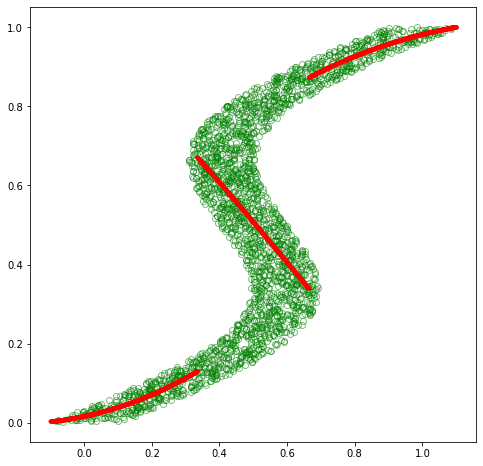

In [45]:
# plot the conditional mode at each point along x
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, cond_mode.data.numpy(), 'r.')
plt.show()

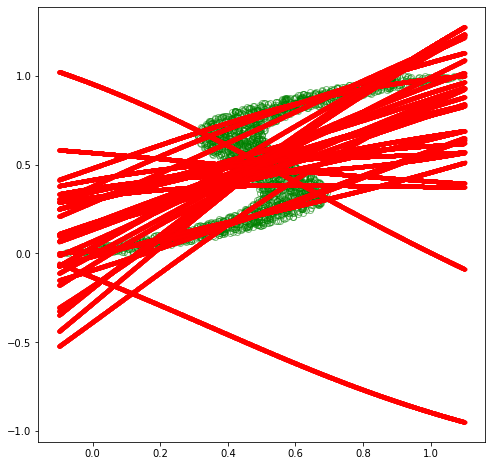

In [46]:
# plot the means at each point along x
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, mu.data.numpy(), 'r.')
plt.show()

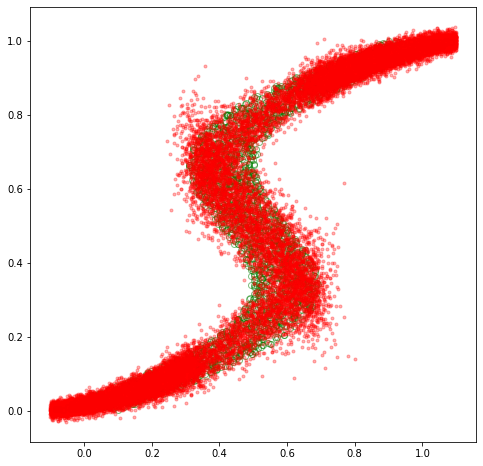

In [47]:
# plot sampled predictions at each point along x
fig = plt.figure(figsize=(8,8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
for i in range(preds.shape[1]):
  plt.plot(x_test, preds.data.numpy()[:, i].reshape(n, 1), 'r.', alpha=0.3)
plt.show()

MDN으로 학습한 결과입니다. 결과로 보니, MDN을 잘 학습을 하여 원래 함수를 잘 찾아가는 현상을 보실수 있으실 겁니다.